In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import u_net as unet

# Set some parameters
BATCH_SIZE = 20 # the higher the better
IMG_WIDTH = 128*2 # for faster computing on kaggle
IMG_HEIGHT = 128*2 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 
Getting and resizing test images ... 
Done!


In [4]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=180, zoom_range=0.2, width_shift_range=0.2,
                                         height_shift_range=0.2, vertical_flip=True, horizontal_flip=True, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=180, zoom_range=0.2, width_shift_range=0.2,
                                        height_shift_range=0.2, vertical_flip=True, horizontal_flip=True, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


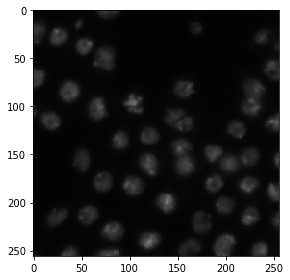

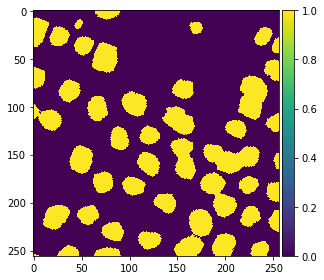

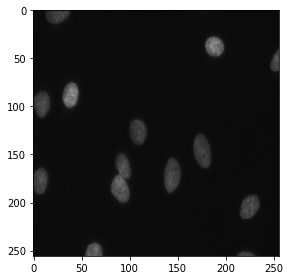

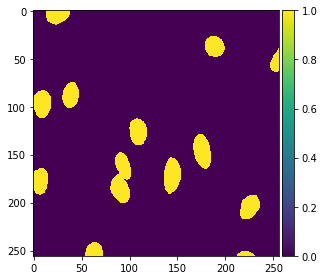

In [5]:
# Checking if the images fit

from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [6]:
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
model = load_model("model-dsbowl2018-2.h5", custom_objects={"bce_dice_loss":unet.bce_dice_loss, "dice_coef":unet.dice_coef,
                                                            "mean_iou":mean_iou})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

In [9]:
earlystopper = EarlyStopping(patience=25, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=5, callbacks=[earlystopper, checkpointer])

Epoch 1/5
249/250 [============================>.] - ETA: 0s - loss: -0.8724 - mean_iou: 0.8947 - binary_crossentropy: 0.0807 - dice_coef: 0.9127
Epoch 00001: val_loss improved from inf to -0.88592, saving model to model-dsbowl2018-2.h5
250/250 [==============================] - 125s 499ms/step - loss: -0.8723 - mean_iou: 0.8948 - binary_crossentropy: 0.0808 - dice_coef: 0.9127 - val_loss: -0.8859 - val_mean_iou: 0.9106 - val_binary_crossentropy: 0.0619 - val_dice_coef: 0.9169
Epoch 2/5
249/250 [============================>.] - ETA: 0s - loss: -0.8853 - mean_iou: 0.9122 - binary_crossentropy: 0.0688 - dice_coef: 0.9197
Epoch 00002: val_loss did not improve
250/250 [==============================] - 120s 479ms/step - loss: -0.8854 - mean_iou: 0.9122 - binary_crossentropy: 0.0687 - dice_coef: 0.9198 - val_loss: -0.8752 - val_mean_iou: 0.9131 - val_binary_crossentropy: 0.0686 - val_dice_coef: 0.9095
Epoch 3/5
249/250 [============================>.] - ETA: 0s - loss: -0.8809 - mean_iou: 

In [54]:
results = model.fit_generator(val_generator, validation_data=train_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=1, callbacks=[earlystopper, checkpointer])

Epoch 1/1
249/250 [============================>.] - ETA: 0s - loss: -0.9470 - mean_iou: 0.9181 - binary_crossentropy: 0.0289 - dice_coef: 0.9614
Epoch 00001: val_loss did not improve
250/250 [==============================] - 94s 377ms/step - loss: -0.9470 - mean_iou: 0.9181 - binary_crossentropy: 0.0289 - dice_coef: 0.9615 - val_loss: -0.0581 - val_mean_iou: 0.9187 - val_binary_crossentropy: 1.1961 - val_dice_coef: 0.6562


In [55]:
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=4, callbacks=[earlystopper, checkpointer])

Epoch 1/4
249/250 [============================>.] - ETA: 0s - loss: -0.8748 - mean_iou: 0.9182 - binary_crossentropy: 0.0818 - dice_coef: 0.9157
Epoch 00001: val_loss did not improve
250/250 [==============================] - 120s 479ms/step - loss: -0.8748 - mean_iou: 0.9182 - binary_crossentropy: 0.0817 - dice_coef: 0.9157 - val_loss: -0.8938 - val_mean_iou: 0.9182 - val_binary_crossentropy: 0.0535 - val_dice_coef: 0.9206
Epoch 2/4
249/250 [============================>.] - ETA: 0s - loss: -0.8798 - mean_iou: 0.9180 - binary_crossentropy: 0.0718 - dice_coef: 0.9157
Epoch 00002: val_loss did not improve
250/250 [==============================] - 119s 476ms/step - loss: -0.8798 - mean_iou: 0.9180 - binary_crossentropy: 0.0718 - dice_coef: 0.9157 - val_loss: -0.8868 - val_mean_iou: 0.9179 - val_binary_crossentropy: 0.0613 - val_dice_coef: 0.9174
Epoch 3/4
249/250 [============================>.] - ETA: 0s - loss: -0.8856 - mean_iou: 0.9179 - binary_crossentropy: 0.0682 - dice_coef: 0.9

MemoryError: 

In [56]:
# Predict on train, val and test
# model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 5ms/step


In [57]:
model.evaluate(X_train, Y_train)

670/670 [==============================] - 6s 9ms/step


[-0.8905795684501306,
 0.9177870618763254,
 0.06465647406320074,
 0.9229079403094391]

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


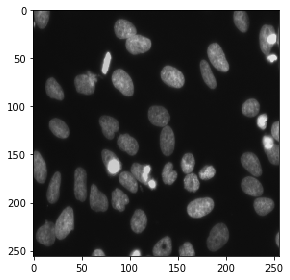

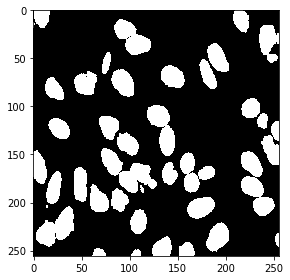

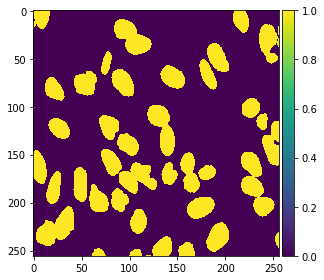

In [58]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


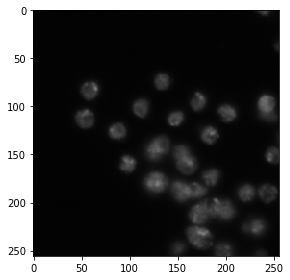

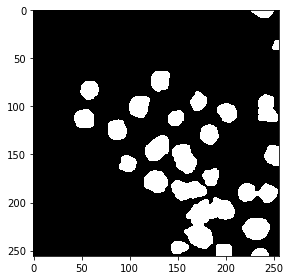

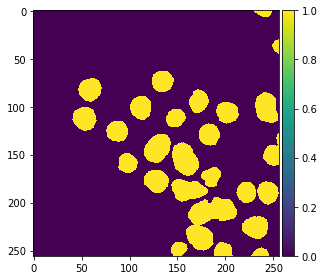

In [59]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


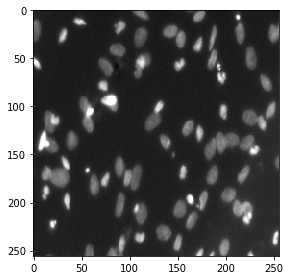

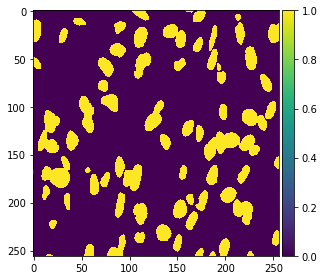

In [60]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [61]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [62]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [63]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1-DA2-batch10_plus_dice_coef_50_beyond_good_and_evilv2.csv', index=False)